In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/taylor/Documents/independent-research/req-files/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']
print(beam_origin_z)
gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 1000

1.14


In [11]:
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [56]:
p = next(pgen)

In [57]:
#The simulated track. The columns are x, y, z, time, energy/nucleon, azimuthal angle, polar angle.
#The positions are in meters, the time is in seconds, and the energy is in MeV/u.
import pytpc.fitting
mcfitter = pytpc.fitting.MCFitter(config)
#p[0][2] = 1.0
res_track = mcfitter.tracker.track_particle(p[0][0], p[0][1], p[0][2]*1, p[0][3], p[0][4], p[0][5])
print(len(res_track))
print(max(res_track[:,2]))

1102
0.5396867185883986


In [58]:
print(p[0][0], p[0][1], p[0][2])
print(p[0][3], p[0][4], p[0][5])

-0.00873360183287714 0.0029808252020044586 0.5396867185883986
2.079133442639659 2.286027299626355 2.028282196420827


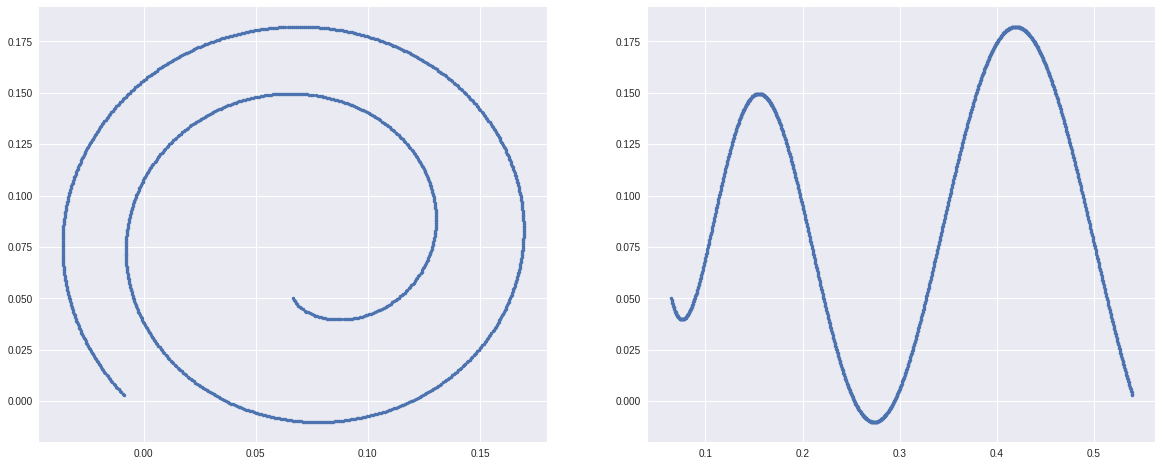

In [59]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(20, 8))

ax[0].plot(res_track[:, 0]*1, res_track[:, 1]*1,'.')
ax[1].plot(res_track[:, 2]*1, res_track[:, 1]*1,'.')

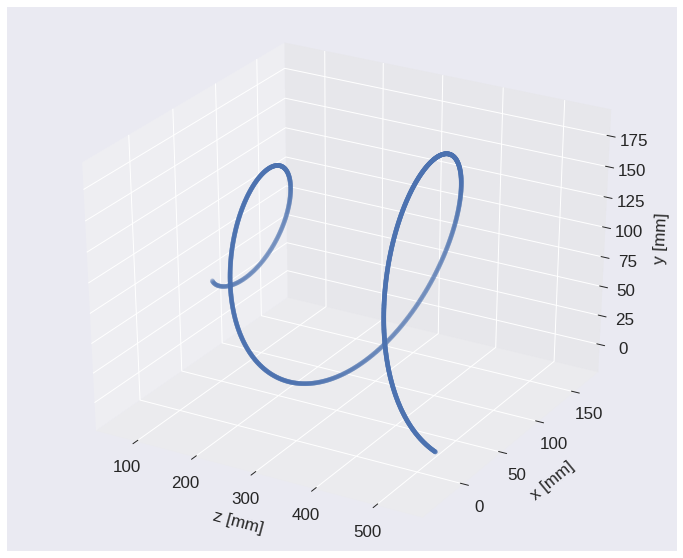

In [86]:
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["xtick.labelsize"] = 17
plt.rcParams["ytick.labelsize"] = 17

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(res_track[:, 2]*1000, res_track[:, 0]*1000,res_track[:,1]*1000)
ax.set_xlabel('\n\n z [mm]')
ax.set_ylabel('\n\n x [mm]')
ax.set_zlabel('\n\n y [mm]')
#plt.savefig('../plots/results/thesis/sim_function.pdf')

In [74]:
sim = EventSimulator(config)

In [75]:
evt, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

In [76]:
print(evt)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


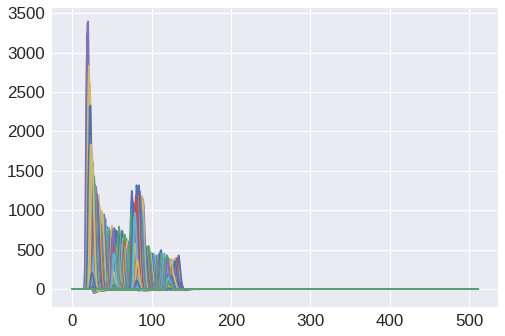

In [77]:
for pad in evt:
    plt.plot(evt.get(pad))

In [78]:
pyevt = sim.convert_event(evt)

In [79]:
#xyt = pyevt.xyzs(peaks_only=True, drift_vel=np.array([-0.0603573 , -0.55178666, -5.14005679]), clock=12.5, return_pads=True, baseline_correction=True, cg_times=True)
xyt = pyevt.xyzs(peaks_only=True, drift_vel=5.2, clock=12.5, return_pads=True, baseline_correction=True, cg_times=True)
#xyt = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
print(max(xyt[:,2]))


559.4718157208595


(-275, 275)

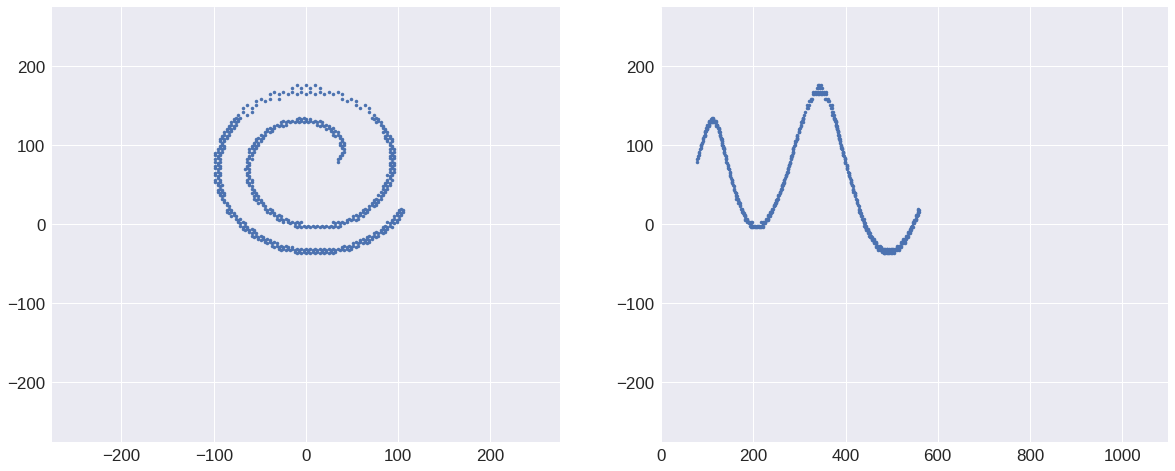

In [80]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(20, 8))

ax[0].plot(xyt[:, 0]*1, xyt[:, 1]*1, '.')
ax[0].set_xlim((-275, 275))
ax[0].set_ylim((-275, 275))
ax[1].plot(xyt[:, 2]*1, xyt[:, 1]*1, '.')
ax[1].set_xlim((0, 1100))
ax[1].set_ylim((-275, 275))

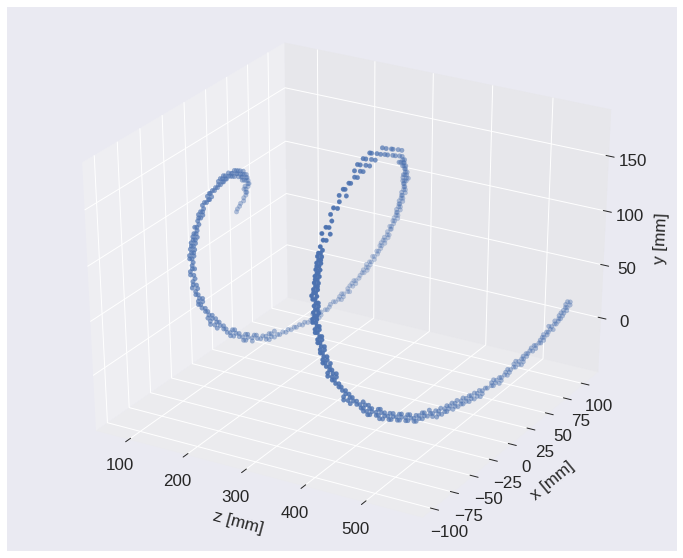

In [87]:
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["xtick.labelsize"] = 17
plt.rcParams["ytick.labelsize"] = 17

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyt[:, 2], xyt[:, 0], xyt[:, 1])
ax.set_xlabel('\n\n z [mm]')
ax.set_ylabel('\n\n x [mm]')
ax.set_zlabel('\n\n y [mm]')
#plt.savefig('../plots/results/thesis/sim_projection.pdf')

In [42]:
print(max(xyt[:,2]))

974.679831121


In [43]:
print(max(res_track[:, 3]))

9.58278073601e-08


# Testing range of simulated data 

In [23]:
maximum_bucket_p = 0
minimum_bucket_p = 1000

#f = pytpc.HDFDataFile('../event-gen/data/ptrain_10000.h5', 'r')
f = pytpc.HDFDataFile('../data/NO-tilt/p_40000.h5', 'r')

for i in range(len(f)):
    z = f[i].xyzs(peaks_only=True, drift_vel=np.array([-0.0603573 , -0.55178666, -5.14005679]), clock=12.5, return_pads=True, baseline_correction=True, cg_times=True)[:,2]

    if max(z) > maximum_bucket_p:
        maximum_bucket_p = max(z)
    if min(z) < minimum_bucket_p:
        minimum_bucket_p = min(z)

/usr/local/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


KeyboardInterrupt: 

In [ ]:
print(maximum_bucket_p)
print(minimum_bucket_p)

In [ ]:
maximum_bucket_C = 0
minimum_bucket_C = 1000

#f = pytpc.HDFDataFile('../event-gen/data/ptrain_10000.h5', 'r')
f = pytpc.HDFDataFile('../data/NO-tilt/C_40000.h5', 'r')

for i in range(len(f)):
    z = f[i].xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)[:,2]

    if max(z) > maximum_bucket_C:
        maximum_bucket_C = max(z)
    if min(z) < minimum_bucket_C:
        minimum_bucket_C = min(z)

In [ ]:
print(maximum_bucket_C)
print(minimum_bucket_C)